<a href="https://colab.research.google.com/github/18521099/DAPHUONGTIEN/blob/master/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import join
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications import xception
from keras.applications.vgg16 import preprocess_input
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from google.colab import drive
from keras.layers import Dense, Activation, Flatten
from keras.layers import Dropout
from keras.models import Model
from keras import optimizers
drive.mount('/mydrive', True)

Mounted at /mydrive


In [ ]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in vgg.layers[:]:
    layer.trainable = False

In [ ]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                16400     
Total params: 40,422,224
Trainable params: 25,707,536
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
path = '/mydrive/My Drive/Dog breed/'
input_size = 224
num_classes = 16
SEED = 1987
labels = pd.read_csv(join(path, 'labels.csv'))
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED) 
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [ ]:
def read_img(img_id, train_or_test, size):
    #Read and Resize image
    img = image.load_img(join(path, train_or_test, '%s.jpg' % img_id), target_size=size)
    #Image as numpy array
    img = image.img_to_array(img)
    return img

In [ ]:
INPUT_SIZE = 224
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:11, 159.99it/s]

Train Images shape: (1777, 224, 224, 3) size: 267,488,256


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
train_batchsize = 100
val_batchsize = 10

train_generator = train_datagen.flow(
    x_train[train_idx],
    ytr,
    batch_size = train_batchsize
)

valid_generator = validation_datagen.flow(
    x_train[valid_idx],
    yv,
    batch_size = val_batchsize
)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch = len(x_train[train_idx])/train_batchsize,
    epochs=20,
    validation_data=valid_generator,
    validation_steps= len(x_train[valid_idx])/val_batchsize,
    verbose=1 
)

Epoch 1/20
15/14 [===============================] - 880s 59s/step - loss: 3.2505 - acc: 0.1519 - val_loss: 2.1261 - val_acc: 0.3207
Epoch 2/20
15/14 [===============================] - 878s 59s/step - loss: 1.8597 - acc: 0.4038 - val_loss: 1.7958 - val_acc: 0.4158
Epoch 3/20
15/14 [===============================] - 878s 59s/step - loss: 1.4746 - acc: 0.5458 - val_loss: 1.5426 - val_acc: 0.4837
Epoch 4/20
15/14 [===============================] - 882s 59s/step - loss: 1.1854 - acc: 0.6317 - val_loss: 2.3377 - val_acc: 0.4076
Epoch 5/20
15/14 [===============================] - 878s 59s/step - loss: 0.9443 - acc: 0.7133 - val_loss: 1.4973 - val_acc: 0.5109
Epoch 6/20
15/14 [===============================] - 882s 59s/step - loss: 0.7401 - acc: 0.8027 - val_loss: 1.2967 - val_acc: 0.5082
Epoch 7/20
15/14 [===============================] - 878s 59s/step - loss: 0.5761 - acc: 0.8453 - val_loss: 1.9111 - val_acc: 0.5489
Epoch 8/20
15/14 [===============================] - 883s 59s/step - 

In [ ]:
import pickle
filename = '/mydrive/My Drive/fine_tuning.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
import pickle
fine_tuning_vgg16 = pickle.load(open('/mydrive/My Drive/fine_tuning.sav', 'rb'))

In [ ]:
def fine_tuning(path_test):
  testImg = image.load_img(path_test,target_size=(224,224))
  testImg = image.img_to_array(testImg)
  fig, ax = plt.subplots(figsize=(5,5))
  ax.imshow(testImg/ 255. )
  ax.axis('off')
  plt.show()
  testImg = preprocess_input(np.expand_dims(testImg.copy(), axis=0))
  x = fine_tuning_vgg16.predict(testImg)
  x = np.where(x[0]==1)
  index = x[0][0]
  print('prediction: ',selected_breed_list[index])

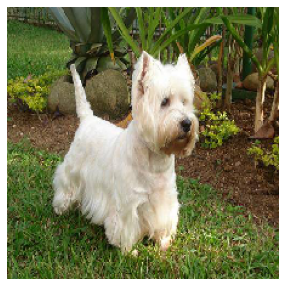

prediction:  cairn


In [ ]:
path_test = '/mydrive/My Drive/Dog breed/test/0c0b3758c1b177b2a2961c1483159898.jpg'
fine_tuning(path_test)